In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.metrics import accuracy_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_colwidth', -1)

import warnings
warnings.simplefilter('ignore')

In [70]:
df = pd.read_csv(r"D:\Data Science\Projects\Analytics vidya\loan Eligibility Prediction\preprocessed.csv")

In [71]:
sample_sub = pd.read_csv(r"D:\Data Science\Projects\Analytics vidya\loan Eligibility Prediction\sample_submission_49d68Cx.csv")

In [72]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,is_train
0,Male,No,0,Graduate,No,5849,0.0,135.5,360.0,1.0,Urban,Y,1
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,1
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,1
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,1


## Converting column values into numbers

In [73]:
df['Gender'].replace({'Male' : 1, 'Female' : 0 }, inplace=True)
df['Married'].replace({'Yes' : 1, 'No' : 0}, inplace = True)
df['Dependents'].replace({'0': 0, '1' : 1, '2' : 2, '3+' : 3}, inplace = True)
df['Education'].replace({ 'Graduate' : 1, 'Not Graduate' : 0}, inplace=True)
df['Self_Employed'].replace({'Yes' : 1, 'No' : 0}, inplace=True)
df['Loan_Status'].replace({'Y' : 1, 'N' : 0}, inplace = True)

In [75]:
df['CoapplicantIncome'] = df['CoapplicantIncome'].astype(int)
df['LoanAmount'] = df['LoanAmount'].astype(int)
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].astype(int)
df['Credit_History'] = df['Credit_History'].astype(int)
#df['Loan_Status'] = df['Loan_Status'].astype(int)

In [76]:
target_col = 'Loan_Status'
check = 'is_train'
features = [c for c in df.columns if c not in [target_col,check]]

cat_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']

num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

## Encoding Features

In [82]:
encode_cols = ['Loan_Amount_Term', 'Property_Area']

#df = pd.get_dummies(df, columns=encode_cols, drop_first=True)

df[encode_cols] = df[encode_cols].apply(le.fit_transform)

---
## Spliting data back into Train and Test

In [83]:
train = df[df['is_train'] == 1].copy()
test = df[ df['is_train'] == 0].copy()

train.drop('is_train', axis = 1, inplace=True)
test.drop('is_train', axis = 1, inplace=True)
test.drop('Loan_Status', axis = 1, inplace=True)

In [84]:
train[target_col] = train[target_col].astype(int)

In [85]:
features = [col for col in train.columns if col not in [target_col]]

---
## Split Train into Train And Validation Set

In [86]:
trn, val = train_test_split(train, test_size = 0.2, random_state=1999, stratify = train[target_col])

In [87]:
###### Input to our model will be features (These Are Inputs)
X_trn, X_val = trn[features], val[features]

###### Output of our model will be target col (Actual Outputs for training and validation)
y_trn, y_val = trn[target_col], val[target_col]

###### Features for the testing data that we will predicting (This is actual test data)
X_test = test[features]

---
## Standard Scaling

In [88]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
_ = scaler.fit(X_trn)

X_trn = scaler.transform(X_trn)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

---
# Testing On Different Models

## 1. Logistic regression

In [89]:
clf = LogisticRegression()
_ = clf.fit(X_trn, y_trn)

preds = clf.predict(X_val)

accuracy_score(y_val, preds)

0.8048780487804879

In [90]:
logit_pred = clf.predict(X_test)

sample_sub['Loan_Status'] = logit_pred
sample_sub['Loan_Status'].replace({1:'Y', 0:'N'}, inplace=True)
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\loan Eligibility Prediction\Submission\Model Building\Logistic.csv", index = False)

---
## 2. Decision Tree

In [91]:
clf = DecisionTreeClassifier(random_state=1999)
_ = clf.fit(X_trn, y_trn)

preds = clf.predict(X_val)

accuracy_score(y_val, preds)

0.7154471544715447

In [92]:
decision_pred = clf.predict(X_test)

sample_sub['Loan_Status'] = decision_pred
sample_sub['Loan_Status'].replace({1:'Y', 0:'N'}, inplace=True)
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\loan Eligibility Prediction\Submission\Model Building\Decision.csv", index = False)

### Hyperparameter Tuning

In [93]:
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV

hyperparam_combs = {
    'max_depth': [i for i in range(1,15)],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]
}

clf = RandomizedSearchCV(DecisionTreeClassifier(),
                         hyperparam_combs,
                         scoring='accuracy',
                         random_state=1,
                         n_iter=50)

search = clf.fit(train[features], train[target_col])

search.best_params_

{'min_samples_split': 40,
 'max_leaf_nodes': 128,
 'max_features': 0.6,
 'max_depth': 5,
 'criterion': 'gini',
 'class_weight': {0: 1, 1: 2}}

In [94]:
optimal_params = {'min_samples_split': 40,
 'max_leaf_nodes': 64,
 'max_features': 0.6,
 'max_depth': 12,
 'criterion': 'gini',
 'class_weight': {0: 1, 1: 3}}

clf = DecisionTreeClassifier(random_state = 1, **optimal_params)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

accuracy_score(y_val, preds_val)

0.8048780487804879

In [95]:
decision_pred = clf.predict(X_test)

sample_sub['Loan_Status'] = decision_pred
sample_sub['Loan_Status'].replace({1:'Y', 0:'N'}, inplace=True)
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\loan Eligibility Prediction\Submission\Model Building\Decision.csv", index = False)

---
## 3. Random Forest

In [96]:
clf = RandomForestClassifier(random_state=1999)
_ = clf.fit(X_trn, y_trn)

preds = clf.predict(X_val)

accuracy_score(y_val, preds)

0.8130081300813008

In [97]:
random_forest_pred = clf.predict(X_test)

sample_sub['Loan_Status'] = random_forest_pred
sample_sub['Loan_Status'].replace({1:'Y', 0:'N'}, inplace=True)
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\loan Eligibility Prediction\Submission\Model Building\RF.csv", index = False)

### Hyperparameter Tuning

In [98]:
hyperparam_combs = {
    'max_depth': [i for i in range(1,15)],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]
}

clf = RandomizedSearchCV(RandomForestClassifier(),
                         hyperparam_combs,
                         scoring='accuracy',
                         random_state=1,
                         n_iter=50,
                        verbose = True,
                        n_jobs = -1)

search = clf.fit(train[features], train[target_col])

search.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    6.7s finished


{'min_samples_split': 10,
 'max_leaf_nodes': 32,
 'max_features': 0.6,
 'max_depth': 7,
 'criterion': 'entropy',
 'class_weight': {0: 1, 1: 1}}

In [99]:
optimal_params = {'min_samples_split': 10,
 'max_leaf_nodes': 32,
 'max_features': 0.6,
 'max_depth': 7,
 'criterion': 'entropy'}

clf = RandomForestClassifier(random_state = 1, **optimal_params)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

accuracy_score(y_val, preds_val)

0.8048780487804879

In [100]:
random_forest_pred = clf.predict(X_test)

sample_sub['Loan_Status'] = random_forest_pred
sample_sub['Loan_Status'].replace({1:'Y', 0:'N'}, inplace=True)
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\loan Eligibility Prediction\Submission\Model Building\RF.csv", index = False)

---
# Validation Strategy

In [101]:
target = train[target_col]

In [102]:
def stratified_kfold(clf, train, test, features):
    
    N_splits = 5
    
    oofs = np.zeros(len(train)) # we will store actual values in this
    preds = np.zeros(len(test)) # we will store predicted values in it
    
    folds = StratifiedKFold(n_splits = N_splits)
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[target_col])):
        print(f'\n--------------------------Fold{fold_ + 1}---------------------------')
        
        ######## Get Train, Validation and Test sets along with Targets ########
        
        ### Training Set
        X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]
        
        ### Validation Set
        X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]
        
        ### Test Dataset
        X_test = test[features]
        
        ################ Scaling Data #################
        scaler = StandardScaler()
        _ = scaler.fit(X_trn)
        
        X_trn = scaler.fit_transform(X_trn)
        X_val = scaler.fit_transform(X_val)
        X_test = scaler.fit_transform(X_test)
        
        
        ################## Fitting and Predicting ##################
        
        _ = clf.fit(X_trn, y_trn)
        
        ### Instead of directly predicting the classes we will obtain the probability of positive class.
        pred_val = clf.predict_proba(X_val)[:, 1]
        pred_test = clf.predict_proba(X_test)[:, 1]
        
        fold_score = accuracy_score(y_val, pred_val.round())
        print(f'\nAccuracy score for validation set is {fold_score}')
        
        oofs[val_idx] = pred_val
        preds+=pred_test / N_splits
    
    oofs_score = accuracy_score(target, oofs.round())
    print(f'\n\nAccuracy score for oofs is {oofs_score}')
    
    return oofs, preds

In [103]:
optimal_params = {'min_samples_split': 10,
 'max_leaf_nodes': 32,
 'max_features': 0.6,
 'max_depth': 7,
 'criterion': 'entropy'}

clf = RandomForestClassifier(random_state = 1, **optimal_params)

rf_oofs, rf_preds = stratified_kfold(clf, train, test, features)


--------------------------Fold1---------------------------

Accuracy score for validation set is 0.8130081300813008

--------------------------Fold2---------------------------

Accuracy score for validation set is 0.7723577235772358

--------------------------Fold3---------------------------

Accuracy score for validation set is 0.7642276422764228

--------------------------Fold4---------------------------

Accuracy score for validation set is 0.8617886178861789

--------------------------Fold5---------------------------

Accuracy score for validation set is 0.8278688524590164


Accuracy score for oofs is 0.8078175895765473


In [104]:
sample_sub['Loan_Status'] = rf_preds.round()
sample_sub['Loan_Status'].replace({1:'Y', 0:'N'}, inplace=True)
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\loan Eligibility Prediction\Submission\Model Building\RF.csv", index = False)

---
# Threshold Optimization

In [105]:
thresholds = np.arange(0,100)/100
for thresh in thresholds:
    oofs_rounded = (rf_oofs > thresh) * 1
    thresh_score = accuracy_score(target, oofs_rounded)
    print(f'Threshhold {thresh} : {thresh_score}')

Threshhold 0.0 : 0.6872964169381107
Threshhold 0.01 : 0.6872964169381107
Threshhold 0.02 : 0.6921824104234527
Threshhold 0.03 : 0.7003257328990228
Threshhold 0.04 : 0.7052117263843648
Threshhold 0.05 : 0.7117263843648208
Threshhold 0.06 : 0.7198697068403909
Threshhold 0.07 : 0.7247557003257329
Threshhold 0.08 : 0.7296416938110749
Threshhold 0.09 : 0.741042345276873
Threshhold 0.1 : 0.747557003257329
Threshhold 0.11 : 0.754071661237785
Threshhold 0.12 : 0.760586319218241
Threshhold 0.13 : 0.7671009771986971
Threshhold 0.14 : 0.7687296416938111
Threshhold 0.15 : 0.7752442996742671
Threshhold 0.16 : 0.7801302931596091
Threshhold 0.17 : 0.7850162866449512
Threshhold 0.18 : 0.7899022801302932
Threshhold 0.19 : 0.7931596091205212
Threshhold 0.2 : 0.7964169381107492
Threshhold 0.21 : 0.7980456026058632
Threshhold 0.22 : 0.7980456026058632
Threshhold 0.23 : 0.7996742671009772
Threshhold 0.24 : 0.7996742671009772
Threshhold 0.25 : 0.8013029315960912
Threshhold 0.26 : 0.8029315960912052
Threshho

In [106]:
## Function For Getting Optimal Threshhold

def get_optimal_threshold(target, oofs):
    thresholds = np.arange(0,100)/100
    thresh_scores = []
    for thresh in thresholds:
        oofs_rounded = (oofs > thresh) * 1
        thresh_score = accuracy_score(target, oofs_rounded)
        thresh_scores.append(thresh_score)
    
    all_thresholds_and_scores = pd.Series(index = thresholds, data = thresh_scores)
    all_thresholds_and_scores.plot(figsize = (10,6), fontsize=14)
    
    plt.xlabel('Threshhold', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    
    return all_thresholds_and_scores.sort_values(ascending=False).index.values[0]

Optimal threshhold is 0.42


0.8110749185667753

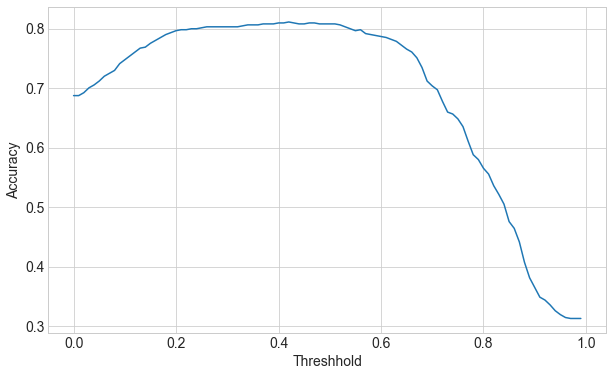

In [107]:
optimal_thresh = get_optimal_threshold(target, rf_oofs)

print(f'Optimal threshhold is {optimal_thresh}')
accuracy_score(target, (rf_oofs > optimal_thresh) * 1)

In [108]:
rf_preds_rounded = (rf_preds > optimal_thresh) * 1

sample_sub['Loan_Status'] = rf_preds_rounded
sample_sub['Loan_Status'].replace({1:'Y', 0:'N'}, inplace=True)
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\loan Eligibility Prediction\Submission\Model Building\RF.csv", index = False)

---
## 4. LightGBM

In [117]:
clf = LGBMClassifier(max_depth=1, random_state=1999)
_ = clf.fit(X_trn, y_trn)

preds = clf.predict(X_val)

accuracy_score(y_val, preds)

0.8130081300813008

In [110]:
lgb_preds = clf.predict(X_test)

sample_sub['Loan_Status'] = lgb_preds
sample_sub['Loan_Status'].replace({1:'Y', 0:'N'}, inplace=True)
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\loan Eligibility Prediction\Submission\Model Building\LGBM.csv", index = False)

In [111]:
hyperparam_combs = {
    'max_depth': [i for i in range(1,15)],
    'learning_rate' : [0.1,0.2,0.3,0.4,0.01, 0.02, 0.03, 0.04,0.05],
    'num_leaves' : [i for i in range(2,50)],
    'reg_alpha' : [1,2,3,4,5,10,15,20,50,100,200,500,1000,2000],
    'reg_lambda' : [1,2,3,4,5,10,15,20,50,100,200,500,1000,2000],
    'min_child_samples' : [i for i in range(2,100)]
}

clf = RandomizedSearchCV(LGBMClassifier(),
                         hyperparam_combs,
                         scoring='accuracy',
                         random_state=1,
                         n_iter=50,
                        verbose = True,
                        n_jobs = -1)

search = clf.fit(train[features], train[target_col])

search.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.6s finished


{'reg_lambda': 4,
 'reg_alpha': 15,
 'num_leaves': 12,
 'min_child_samples': 54,
 'max_depth': 1,
 'learning_rate': 0.1}

In [118]:
params ={'reg_lambda': 4,
 'reg_alpha': 15,
 'num_leaves': 12,
 'min_child_samples': 54,
 'max_depth': 1,
 'learning_rate': 0.1}

clf = LGBMClassifier(random_state=1999, **params)
_ = clf.fit(X_trn, y_trn)

preds = clf.predict(X_val)

accuracy_score(y_val, preds)

0.8130081300813008

In [119]:
lgb_preds = clf.predict(X_test)

sample_sub['Loan_Status'] = lgb_preds
sample_sub['Loan_Status'].replace({1:'Y', 0:'N'}, inplace=True)
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\loan Eligibility Prediction\Submission\Model Building\LGBM.csv", index = False)

In [120]:
lgb_oofs,lgb_preds = stratified_kfold(clf, train, test, features)


--------------------------Fold1---------------------------

Accuracy score for validation set is 0.8048780487804879

--------------------------Fold2---------------------------

Accuracy score for validation set is 0.7804878048780488

--------------------------Fold3---------------------------

Accuracy score for validation set is 0.7804878048780488

--------------------------Fold4---------------------------

Accuracy score for validation set is 0.8617886178861789

--------------------------Fold5---------------------------

Accuracy score for validation set is 0.819672131147541


Accuracy score for oofs is 0.8094462540716613


In [121]:
sample_sub['Loan_Status'] = lgb_preds.round()
sample_sub['Loan_Status'].replace({1:'Y', 0:'N'}, inplace=True)
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\loan Eligibility Prediction\Submission\Model Building\LGBM.csv", index = False)

Optimal threshhold is 0.49


0.8094462540716613

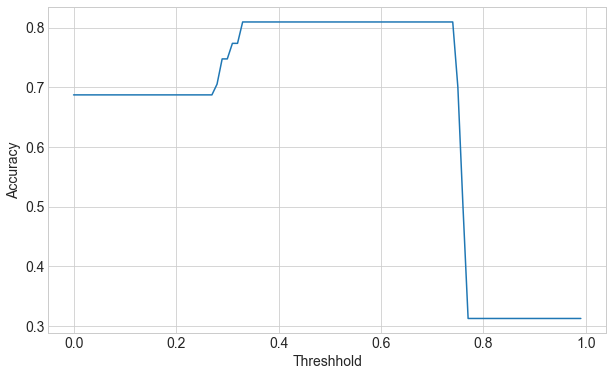

In [122]:
optimal_thresh = get_optimal_threshold(target, lgb_oofs)

print(f'Optimal threshhold is {optimal_thresh}')
accuracy_score(target, (lgb_oofs > optimal_thresh) * 1)

---
# Function to run Gradient Boosting

In [123]:
def boosting(clf, fit_params,train, test, features):
    
    N_splits = 5
    
    oofs = np.zeros(len(train)) # we will store actual values in this
    preds = np.zeros(len(test)) # we will store predicted values in it
    
    folds = StratifiedKFold(n_splits = N_splits)
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[target_col])):
        print(f'\n--------------------------Fold{fold_ + 1}---------------------------')
        
        ######## Get Train, Validation and Test sets along with Targets ########
        
        ### Training Set
        X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]
        
        ### Validation Set
        X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]
        
        ### Test Dataset
        X_test = test[features]
        
        ################ Scaling Data #################
        scaler = StandardScaler()
        _ = scaler.fit(X_trn)
        
        X_trn = scaler.fit_transform(X_trn)
        X_val = scaler.fit_transform(X_val)
        X_test = scaler.fit_transform(X_test)
        
        
        ################## Fitting and Predicting ##################
        
        _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)
        
        ### Instead of directly predicting the classes we will obtain the probability of positive class.
        pred_val = clf.predict_proba(X_val)[:, 1]
        pred_test = clf.predict_proba(X_test)[:, 1]
        
        fold_score = accuracy_score(y_val, pred_val.round())
        print(f'\nAccuracy score for validation set is {fold_score}')
        
        oofs[val_idx] = pred_val
        preds+=pred_test / N_splits
    
    oofs_score = accuracy_score(target, oofs.round())
    print(f'\n\nAccuracy score for oofs is {oofs_score}')
    
    return oofs, preds

## 1. LGBM


--------------------------Fold1---------------------------
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.506094
[200]	valid_0's binary_logloss: 0.505443
[300]	valid_0's binary_logloss: 0.505438
[400]	valid_0's binary_logloss: 0.505438
[500]	valid_0's binary_logloss: 0.505438
[600]	valid_0's binary_logloss: 0.505438
[700]	valid_0's binary_logloss: 0.505438
[800]	valid_0's binary_logloss: 0.505438
[900]	valid_0's binary_logloss: 0.505438
[1000]	valid_0's binary_logloss: 0.505438
[1100]	valid_0's binary_logloss: 0.505438
[1200]	valid_0's binary_logloss: 0.505438
[1300]	valid_0's binary_logloss: 0.505438
[1400]	valid_0's binary_logloss: 0.505438
[1500]	valid_0's binary_logloss: 0.505438
[1600]	valid_0's binary_logloss: 0.505438
[1700]	valid_0's binary_logloss: 0.505438
[1800]	valid_0's binary_logloss: 0.505438
[1900]	valid_0's binary_logloss: 0.505438
Early stopping, best iteration is:
[1859]	valid_0's binary_logloss: 0.505438

Accuracy sc

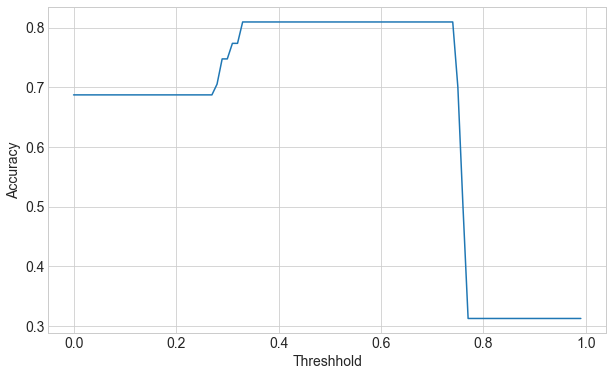

In [124]:
params = {'reg_lambda': 4,
 'reg_alpha': 15,
 'num_leaves': 12,
 'min_child_samples': 54,
 'max_depth': 1,
 'learning_rate': 0.1}

clf = LGBMClassifier(n_estimators= 2000,colsample_bytree=0.5, random_state=1999, **params)

fit_params = {'verbose': 100, 'early_stopping_rounds': 100}

lgb_oofs ,lgb_preds = boosting(clf, fit_params, train, test, features)

optimal_thresh = get_optimal_threshold(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = accuracy_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized accuracy is {optimized_f1}')

In [125]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1

sample_sub['Loan_Status'] = lgb_preds_rounded
sample_sub['Loan_Status'].replace({1:'Y', 0:'N'}, inplace=True)
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\loan Eligibility Prediction\Submission\Model Building\LGBM.csv", index = False)

## 2. Catboost

In [126]:
clf = CatBoostClassifier()
_ = clf.fit(X_trn, y_trn)

preds = clf.predict(X_val)

accuracy_score(y_val, preds)

Learning rate set to 0.007604
0:	learn: 0.6886556	total: 1.81ms	remaining: 1.81s
1:	learn: 0.6847282	total: 3.27ms	remaining: 1.63s
2:	learn: 0.6809016	total: 4.75ms	remaining: 1.58s
3:	learn: 0.6772428	total: 6.22ms	remaining: 1.55s
4:	learn: 0.6731891	total: 7.57ms	remaining: 1.51s
5:	learn: 0.6691762	total: 9.13ms	remaining: 1.51s
6:	learn: 0.6659311	total: 10.4ms	remaining: 1.47s
7:	learn: 0.6621030	total: 11.7ms	remaining: 1.45s
8:	learn: 0.6586711	total: 12.8ms	remaining: 1.41s
9:	learn: 0.6545526	total: 14.3ms	remaining: 1.41s
10:	learn: 0.6515603	total: 15.1ms	remaining: 1.35s
11:	learn: 0.6485665	total: 16.4ms	remaining: 1.35s
12:	learn: 0.6451693	total: 17.7ms	remaining: 1.34s
13:	learn: 0.6417082	total: 19ms	remaining: 1.34s
14:	learn: 0.6381794	total: 20.5ms	remaining: 1.35s
15:	learn: 0.6350575	total: 21.4ms	remaining: 1.31s
16:	learn: 0.6318275	total: 22.8ms	remaining: 1.31s
17:	learn: 0.6285988	total: 24.1ms	remaining: 1.31s
18:	learn: 0.6250612	total: 25.5ms	remaining: 

272:	learn: 0.3860898	total: 342ms	remaining: 911ms
273:	learn: 0.3859237	total: 343ms	remaining: 909ms
274:	learn: 0.3853721	total: 344ms	remaining: 908ms
275:	learn: 0.3851266	total: 346ms	remaining: 907ms
276:	learn: 0.3845680	total: 347ms	remaining: 906ms
277:	learn: 0.3841605	total: 348ms	remaining: 904ms
278:	learn: 0.3838299	total: 349ms	remaining: 903ms
279:	learn: 0.3834557	total: 351ms	remaining: 902ms
280:	learn: 0.3830534	total: 352ms	remaining: 900ms
281:	learn: 0.3827158	total: 353ms	remaining: 899ms
282:	learn: 0.3826287	total: 354ms	remaining: 897ms
283:	learn: 0.3822579	total: 355ms	remaining: 895ms
284:	learn: 0.3820201	total: 356ms	remaining: 894ms
285:	learn: 0.3817003	total: 358ms	remaining: 893ms
286:	learn: 0.3812318	total: 359ms	remaining: 892ms
287:	learn: 0.3807619	total: 360ms	remaining: 890ms
288:	learn: 0.3804002	total: 361ms	remaining: 889ms
289:	learn: 0.3799537	total: 363ms	remaining: 888ms
290:	learn: 0.3794348	total: 364ms	remaining: 887ms
291:	learn: 

551:	learn: 0.3085704	total: 683ms	remaining: 554ms
552:	learn: 0.3083560	total: 684ms	remaining: 553ms
553:	learn: 0.3082165	total: 685ms	remaining: 552ms
554:	learn: 0.3080699	total: 686ms	remaining: 550ms
555:	learn: 0.3078861	total: 688ms	remaining: 549ms
556:	learn: 0.3076355	total: 689ms	remaining: 548ms
557:	learn: 0.3074642	total: 690ms	remaining: 547ms
558:	learn: 0.3072783	total: 691ms	remaining: 545ms
559:	learn: 0.3070785	total: 693ms	remaining: 544ms
560:	learn: 0.3069981	total: 694ms	remaining: 543ms
561:	learn: 0.3068131	total: 695ms	remaining: 542ms
562:	learn: 0.3067886	total: 696ms	remaining: 540ms
563:	learn: 0.3064854	total: 697ms	remaining: 539ms
564:	learn: 0.3063655	total: 698ms	remaining: 538ms
565:	learn: 0.3061666	total: 699ms	remaining: 536ms
566:	learn: 0.3059397	total: 701ms	remaining: 535ms
567:	learn: 0.3057259	total: 702ms	remaining: 534ms
568:	learn: 0.3055231	total: 703ms	remaining: 533ms
569:	learn: 0.3053366	total: 704ms	remaining: 531ms
570:	learn: 

830:	learn: 0.2592413	total: 1.02s	remaining: 208ms
831:	learn: 0.2591780	total: 1.02s	remaining: 207ms
832:	learn: 0.2590295	total: 1.03s	remaining: 206ms
833:	learn: 0.2588908	total: 1.03s	remaining: 205ms
834:	learn: 0.2587222	total: 1.03s	remaining: 203ms
835:	learn: 0.2584799	total: 1.03s	remaining: 202ms
836:	learn: 0.2583503	total: 1.03s	remaining: 201ms
837:	learn: 0.2580803	total: 1.03s	remaining: 200ms
838:	learn: 0.2579699	total: 1.03s	remaining: 199ms
839:	learn: 0.2579345	total: 1.04s	remaining: 197ms
840:	learn: 0.2578165	total: 1.04s	remaining: 196ms
841:	learn: 0.2575408	total: 1.04s	remaining: 195ms
842:	learn: 0.2574104	total: 1.04s	remaining: 194ms
843:	learn: 0.2573633	total: 1.04s	remaining: 193ms
844:	learn: 0.2572255	total: 1.04s	remaining: 191ms
845:	learn: 0.2570739	total: 1.04s	remaining: 190ms
846:	learn: 0.2569456	total: 1.04s	remaining: 189ms
847:	learn: 0.2567385	total: 1.05s	remaining: 188ms
848:	learn: 0.2566583	total: 1.05s	remaining: 186ms
849:	learn: 

0.8048780487804879

In [127]:
cat_preds = clf.predict(X_test)

sample_sub['Loan_Status'] = cat_preds
sample_sub['Loan_Status'].replace({1:'Y', 0:'N'}, inplace=True)
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\loan Eligibility Prediction\Submission\Model Building\CAT.csv", index = False)


--------------------------Fold1---------------------------
Learning rate set to 0.019663
0:	learn: 0.6823101	test: 0.6851720	best: 0.6851720 (0)	total: 1.83ms	remaining: 3.66s
100:	learn: 0.3952018	test: 0.4890198	best: 0.4890198 (100)	total: 129ms	remaining: 2.42s
200:	learn: 0.3234558	test: 0.4968279	best: 0.4878152 (129)	total: 252ms	remaining: 2.25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.487815185
bestIteration = 129

Shrink model to first 130 iterations.

Accuracy score for validation set is 0.7967479674796748

--------------------------Fold2---------------------------
Learning rate set to 0.019663
0:	learn: 0.6821964	test: 0.6846623	best: 0.6846623 (0)	total: 1.59ms	remaining: 3.18s
100:	learn: 0.3846265	test: 0.5333794	best: 0.5295536 (72)	total: 125ms	remaining: 2.35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5295536244
bestIteration = 72

Shrink model to first 73 iterations.

Accuracy score for validation set is 0.78048

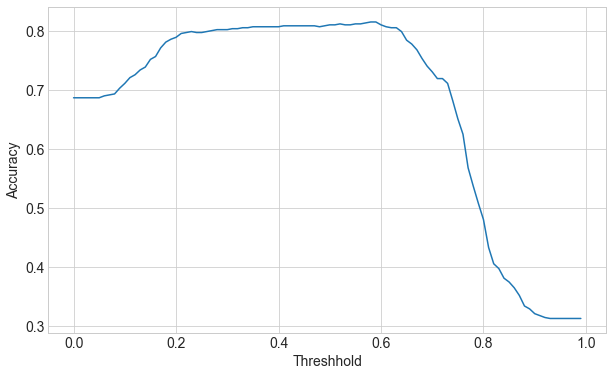

In [128]:

clf = CatBoostClassifier(n_estimators= 2000, random_state=1999)

fit_params = {'verbose': 100, 'early_stopping_rounds': 100}

cat_oofs ,cat_preds = boosting(clf, fit_params, train, test, features)

optimal_thresh = get_optimal_threshold(target, cat_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = accuracy_score(target, (cat_oofs > optimal_thresh) * 1)
print(f'Optimized accuracy is {optimized_f1}')

In [130]:
cat_preds_rounded = (cat_preds > optimal_thresh) * 1

sample_sub['Loan_Status'] = cat_preds_rounded
sample_sub['Loan_Status'].replace({1:'Y', 0:'N'}, inplace=True)
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\loan Eligibility Prediction\Submission\Model Building\cat_tune.csv", index = False)

---
## 3. XGBoost


--------------------------Fold1---------------------------
[0]	validation_0-error:0.25203
Will train until validation_0-error hasn't improved in 100 rounds.
[100]	validation_0-error:0.26829
Stopping. Best iteration:
[2]	validation_0-error:0.17886


Accuracy score for validation set is 0.8211382113821138

--------------------------Fold2---------------------------
[0]	validation_0-error:0.26016
Will train until validation_0-error hasn't improved in 100 rounds.
[100]	validation_0-error:0.27642
Stopping. Best iteration:
[2]	validation_0-error:0.22764


Accuracy score for validation set is 0.7723577235772358

--------------------------Fold3---------------------------
[0]	validation_0-error:0.23577
Will train until validation_0-error hasn't improved in 100 rounds.
[100]	validation_0-error:0.26016
Stopping. Best iteration:
[12]	validation_0-error:0.21951


Accuracy score for validation set is 0.7804878048780488

--------------------------Fold4---------------------------
[0]	validation_0-erro

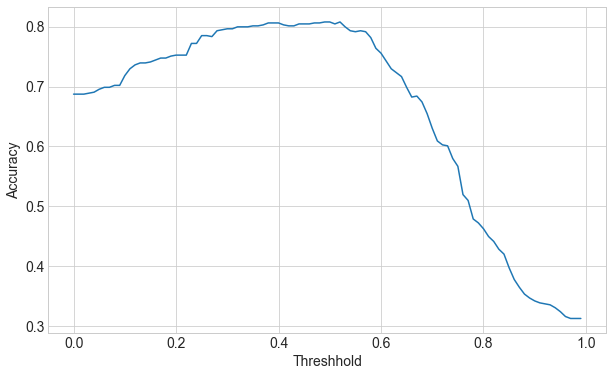

In [131]:

clf = XGBClassifier(n_estimators=500, random_state=1999)

fit_params = {'verbose': 100, 'early_stopping_rounds': 100}

lgb_oofs ,lgb_preds = boosting(clf, fit_params, train, test, features)

optimal_thresh = get_optimal_threshold(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = accuracy_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized accuracy is {optimized_f1}')

In [132]:
xgb_preds_rounded = (cat_preds > optimal_thresh) * 1

sample_sub['Loan_Status'] = xgb_preds_rounded
sample_sub['Loan_Status'].replace({1:'Y', 0:'N'}, inplace=True)
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\loan Eligibility Prediction\Submission\Model Building\xgb.csv", index = False)